In [1]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalMaxPooling2D, Input, Flatten, MaxPooling2D, Lambda, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# paths to data directory
data_dir = 'C:/Users/miche/NN/ML_hw2/Data'

datagen = ImageDataGenerator(rescale=1 / 255.0)

batch_size = 9236
generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42)

Found 9236 images belonging to 8 classes.


In [3]:
data, y = next(generator)

print(data.shape)
print(y.shape)

(9236, 32, 32, 3)
(9236, 8)


In [4]:
print(generator.class_indices.keys())

dict_keys(['Cranberries', 'Furniture___Wood_Polishes', 'Lollipops', 'Mineral_Water', 'decorative_tray', 'pickled_vegetables', 'salad_bowl', 'steak_knives'])


In [5]:
class_names = ['Cranberries', 'Furniture_&_Wood_Polishes', 'Lollipops', 'Mineral_Water', 'decorative_tray', 
               'pickled_vegetables', 'salad_bowl', 'steak_knives']

def stampa(ds, ds_labels, class_names):
  fig = plt.figure(figsize=(10,7))
  for i in range(8):
      plt.subplot(4,2,i+1)
      plt.tight_layout()
      plt.imshow(ds[i])
      plt.title("Oggetto: {}".format(class_names[(np.where(ds_labels[i]==1)[0][0])]))
      plt.xticks([])
      plt.yticks([])

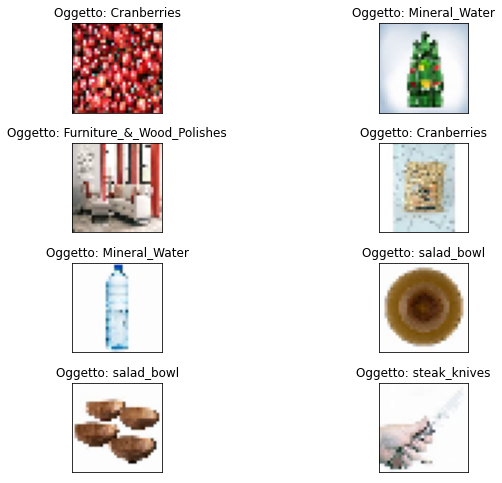

In [6]:
# plotting some samples
stampa(data, y, class_names)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data,y,test_size=0.15)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.20)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(6280, 32, 32, 3)
(1570, 32, 32, 3)
(1386, 32, 32, 3)


In [8]:
train_labels = np.empty(len(y_train), dtype=int)
val_labels = np.empty(len(y_val), dtype=int)
test_labels = np.empty(len(y_test), dtype=int)

for i in range(len(y_train)):
    train_labels[i] = (np.where(y_train[i]==1)[0][0])
    
for i in range(len(y_val)):
    val_labels[i] = (np.where(y_val[i]==1)[0][0])
    
for j in range(len(y_test)):
    test_labels[j] = (np.where(y_test[j]==1)[0][0])

In [9]:
train_counts = np.unique(train_labels, return_counts=True)[1]
val_counts = np.unique(val_labels, return_counts=True)[1]
test_counts = np.unique(test_labels, return_counts=True)[1]

for i in range(8):
    print('Number of samples in the training set belonging to class ', class_names[i], ' = ', train_counts[i])
    print('Number of samples in the validation set belonging to class ', class_names[i], ' = ', val_counts[i])
    print('Number of samples in the test set belonging to class ', class_names[i], ' = ', test_counts[i])
    print()

Number of samples in the training set belonging to class  Cranberries  =  780
Number of samples in the validation set belonging to class  Cranberries  =  184
Number of samples in the test set belonging to class  Cranberries  =  182

Number of samples in the training set belonging to class  Furniture_&_Wood_Polishes  =  915
Number of samples in the validation set belonging to class  Furniture_&_Wood_Polishes  =  226
Number of samples in the test set belonging to class  Furniture_&_Wood_Polishes  =  180

Number of samples in the training set belonging to class  Lollipops  =  777
Number of samples in the validation set belonging to class  Lollipops  =  188
Number of samples in the test set belonging to class  Lollipops  =  178

Number of samples in the training set belonging to class  Mineral_Water  =  734
Number of samples in the validation set belonging to class  Mineral_Water  =  180
Number of samples in the test set belonging to class  Mineral_Water  =  162

Number of samples in the t

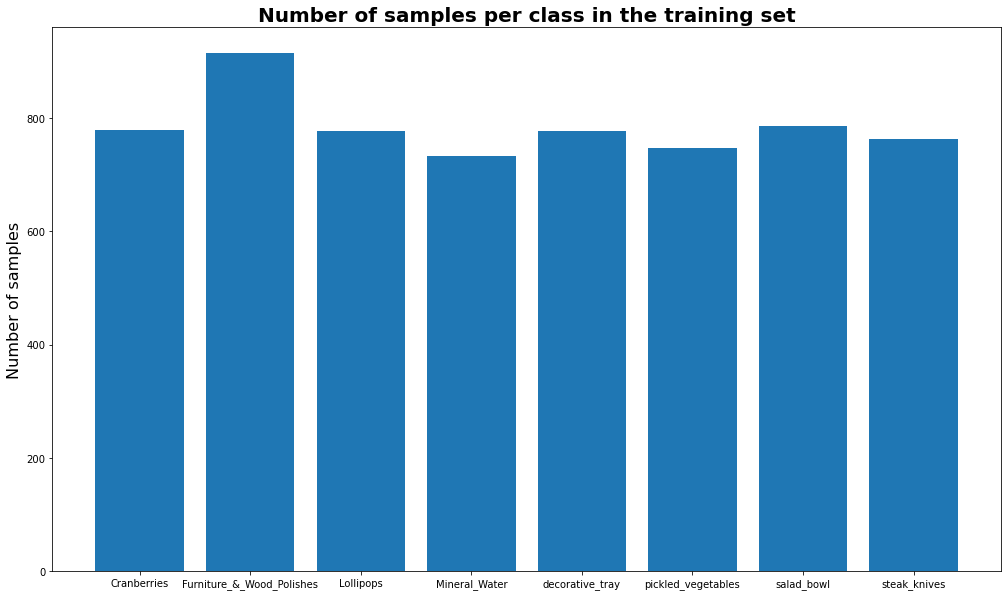

In [10]:
plt.figure(figsize=(17,10))
plt.bar(x=class_names, height=train_counts)
plt.ylabel('Number of samples', fontsize=16)

plt.title('Number of samples per class in the training set', 
          fontweight ="bold", fontsize=20) 
plt.show()

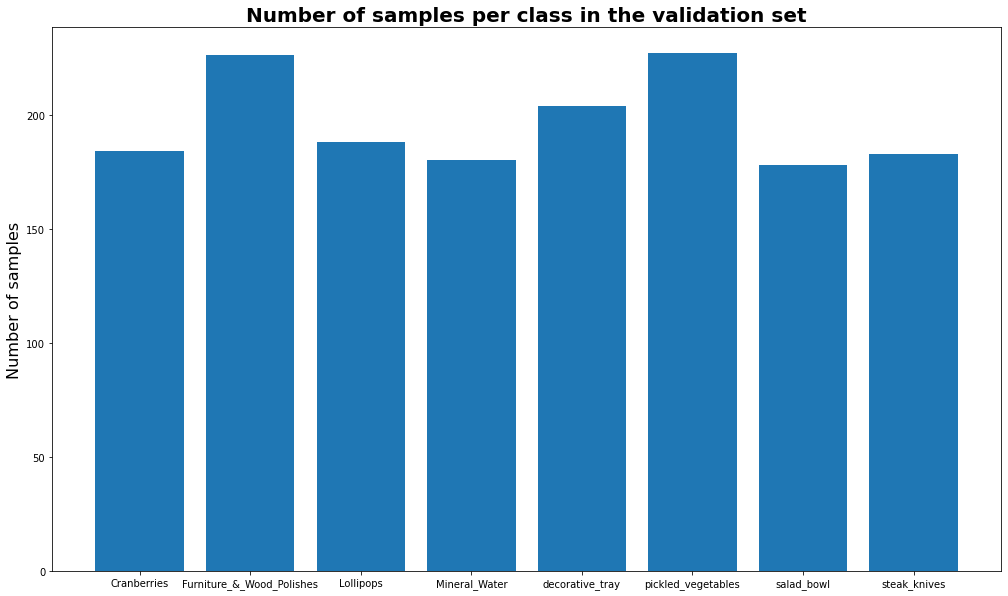

In [11]:
plt.figure(figsize=(17,10))
plt.bar(x=class_names, height=val_counts)
plt.ylabel('Number of samples', fontsize=16)

plt.title('Number of samples per class in the validation set', 
          fontweight ="bold", fontsize=20) 
plt.show()

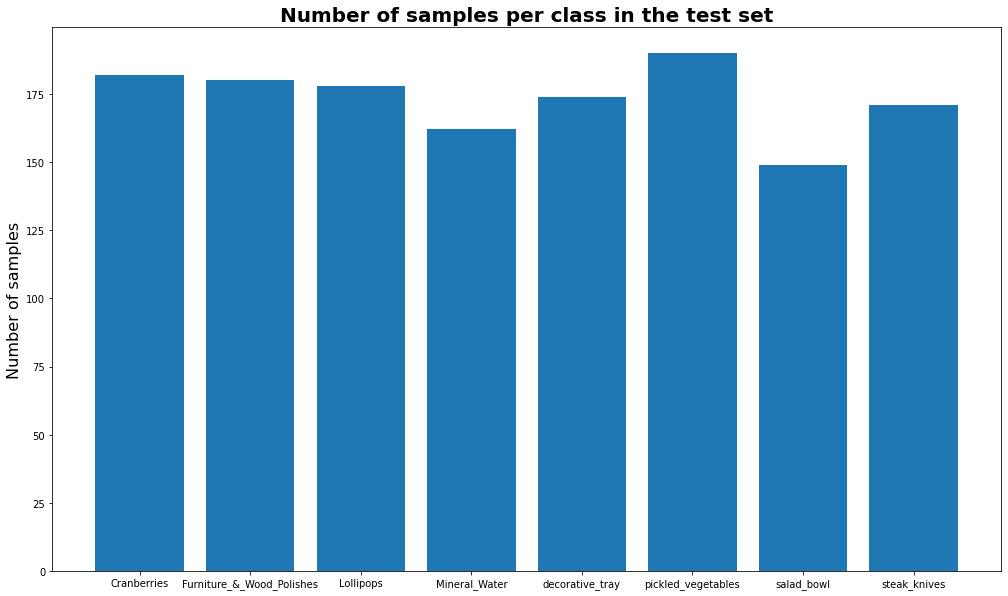

In [12]:
plt.figure(figsize=(17,10))
plt.bar(x=class_names, height=test_counts)
plt.ylabel('Number of samples', fontsize=16)

plt.title('Number of samples per class in the test set', 
          fontweight ="bold", fontsize=20) 
plt.show()

In [13]:
print('Training set shape: ', x_train.shape)
print(y_train.shape)
print('Validation set shape: ', x_test.shape)
print(y_test.shape)

Training set shape:  (6280, 32, 32, 3)
(6280, 8)
Validation set shape:  (1386, 32, 32, 3)
(1386, 8)


In [14]:
model = Sequential(
    [
        Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32,32,3)),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        GlobalMaxPooling2D(),

        Dense(64, activation='relu'),
        Dense(8, activation='softmax')
    ]
)

In [15]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.save('C:/Users/miche/NN/ML_hw2/mymodel.h5')

In [16]:
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
logdir = 'C:/Users/miche/NN/ML_hw2'

In [17]:
history = model.fit(x_train, y_train,
                    batch_size=150, epochs=100,
                    validation_data=(x_val, y_val),
                   callbacks=[callback])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
42/42 [==============================] - ETA: 0s - loss: 1.9462 - accuracy: 0.2344WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000209872680D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attac

42/42 [==============================] - 1s 27ms/step - loss: 0.4498 - accuracy: 0.8411 - val_loss: 0.8617 - val_accuracy: 0.7191
Epoch 46/100
42/42 [==============================] - 1s 27ms/step - loss: 0.4846 - accuracy: 0.8280 - val_loss: 0.8733 - val_accuracy: 0.7223
Epoch 47/100
42/42 [==============================] - 1s 27ms/step - loss: 0.4715 - accuracy: 0.8295 - val_loss: 0.8577 - val_accuracy: 0.7172
Epoch 48/100
42/42 [==============================] - 1s 27ms/step - loss: 0.4454 - accuracy: 0.8420 - val_loss: 0.8836 - val_accuracy: 0.7057
Epoch 49/100
42/42 [==============================] - 1s 27ms/step - loss: 0.4419 - accuracy: 0.8438 - val_loss: 0.8858 - val_accuracy: 0.7146
Epoch 50/100
42/42 [==============================] - 1s 26ms/step - loss: 0.4288 - accuracy: 0.8451 - val_loss: 0.8651 - val_accuracy: 0.7242
Epoch 51/100
42/42 [==============================] - 1s 27ms/step - loss: 0.4321 - accuracy: 0.8475 - val_loss: 0.8688 - val_accuracy: 0.7261
Epoch 52/100

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         7

In [19]:
def plot_metrics(history):
  # plotting the metrics
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

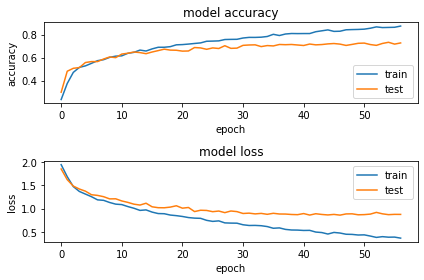

In [20]:
plot_metrics(history)

In [21]:
loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

44/44 - 0s - loss: 0.8318 - accuracy: 0.7403
Test Loss 0.8318399786949158
Test Accuracy 0.7402597665786743


In [22]:
predicted_classes_crossentropy = np.argmax(model.predict(x_test), axis=-1)

# see which we predicted correctly and which not
correct_indices_crossentropy = np.nonzero(predicted_classes_crossentropy == test_labels)[0]
incorrect_indices_crossentropy = np.nonzero(predicted_classes_crossentropy != test_labels)[0]
print()
print(len(correct_indices_crossentropy)," classified correctly")
print(len(incorrect_indices_crossentropy)," classified incorrectly")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

1026  classified correctly
360  classified incorrectly


In [23]:
t0= time.process_time()
y_pred_sm = model.predict(x_test)
t1 = time.process_time() - t0
print("Time elapsed: ", t1, " seconds")

y_pred = np.argmax(y_pred_sm, axis=1)

Time elapsed:  0.234375  seconds


In [24]:
def stampa_eval(correct_indices, incorrect_indices, predicted_classes):
  # adapt figure size to accomodate 18 subplots
  plt.rcParams['figure.figsize'] = (18,15)

  figure_evaluation = plt.figure()

  # plot 9 correct predictions
  for i, correct in enumerate(correct_indices[:9]):
      plt.subplot(6,3,i+1)
      plt.imshow(x_test[correct], interpolation='none')
      plt.title(
        "Predicted: {}, Truth: {}".format(class_names[predicted_classes[correct]],
                                          class_names[test_labels[correct]]))
      plt.xticks([])
      plt.yticks([])

  # plot 9 incorrect predictions
  for i, incorrect in enumerate(incorrect_indices[:9]):
      plt.subplot(6,3,i+10)
      plt.imshow(x_test[incorrect], interpolation='none')
      plt.title(
        "Predicted {}, Truth: {}".format(class_names[predicted_classes[incorrect]], 
                                        class_names[test_labels[incorrect]]))
      plt.xticks([])
      plt.yticks([])

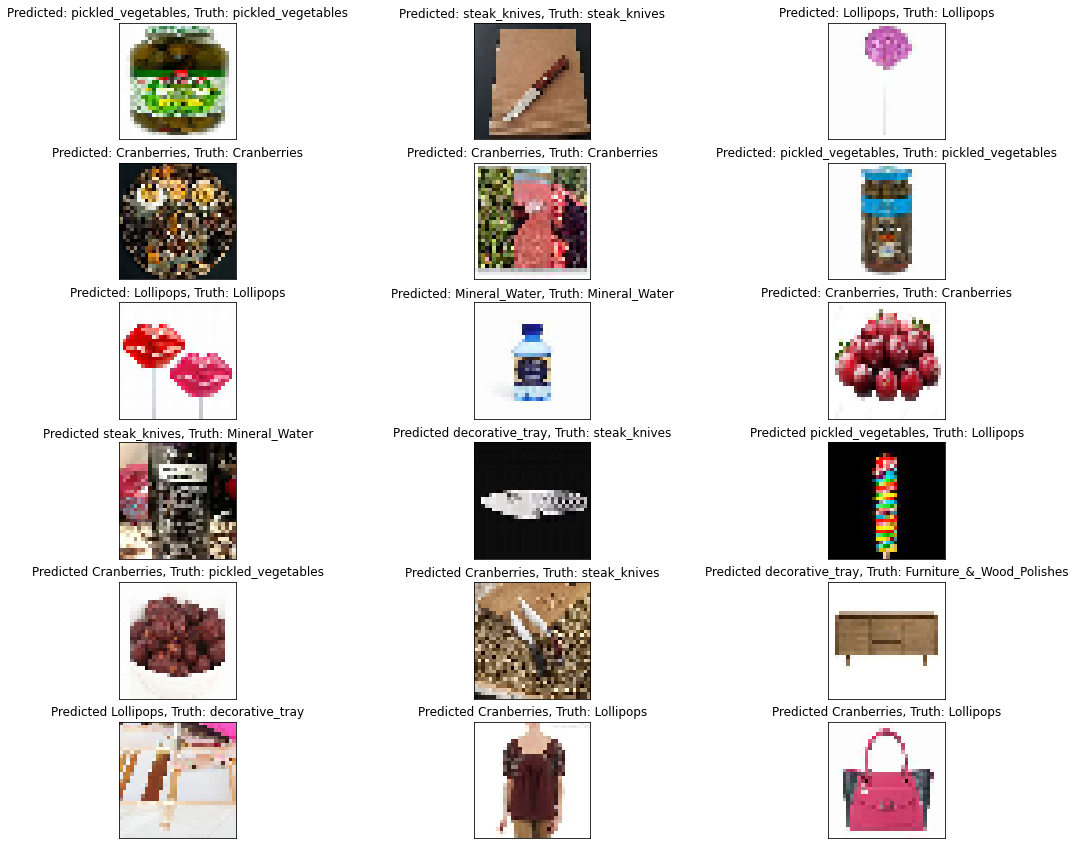

In [25]:
stampa_eval(correct_indices_crossentropy, incorrect_indices_crossentropy, predicted_classes_crossentropy)

In [26]:
acc = model.evaluate(x_test, y_test)
print("Accuracy %.3f" %acc[-1])

44/44 [==============================] - 0s 7ms/step - loss: 0.8318 - accuracy: 0.7403
Accuracy 0.740


In [27]:
print(classification_report(test_labels, y_pred, labels=None))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       182
           1       0.81      0.79      0.80       180
           2       0.70      0.71      0.71       178
           3       0.89      0.83      0.86       162
           4       0.65      0.66      0.65       174
           5       0.74      0.71      0.72       190
           6       0.67      0.69      0.68       149
           7       0.83      0.75      0.79       171

    accuracy                           0.74      1386
   macro avg       0.75      0.74      0.74      1386
weighted avg       0.74      0.74      0.74      1386



In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[[142   3  10   0   5  16   3   3]
 [  4 143   3   1  14   5   3   7]
 [ 25   3 127   9   3   6   2   3]
 [  1   1   8 134   2   4  10   2]
 [  7  15   4   1 114   6  20   7]
 [ 18   4  18   0   7 134   6   3]
 [  6   4   8   2  17   7 103   2]
 [  9   4   4   3  14   2   6 129]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

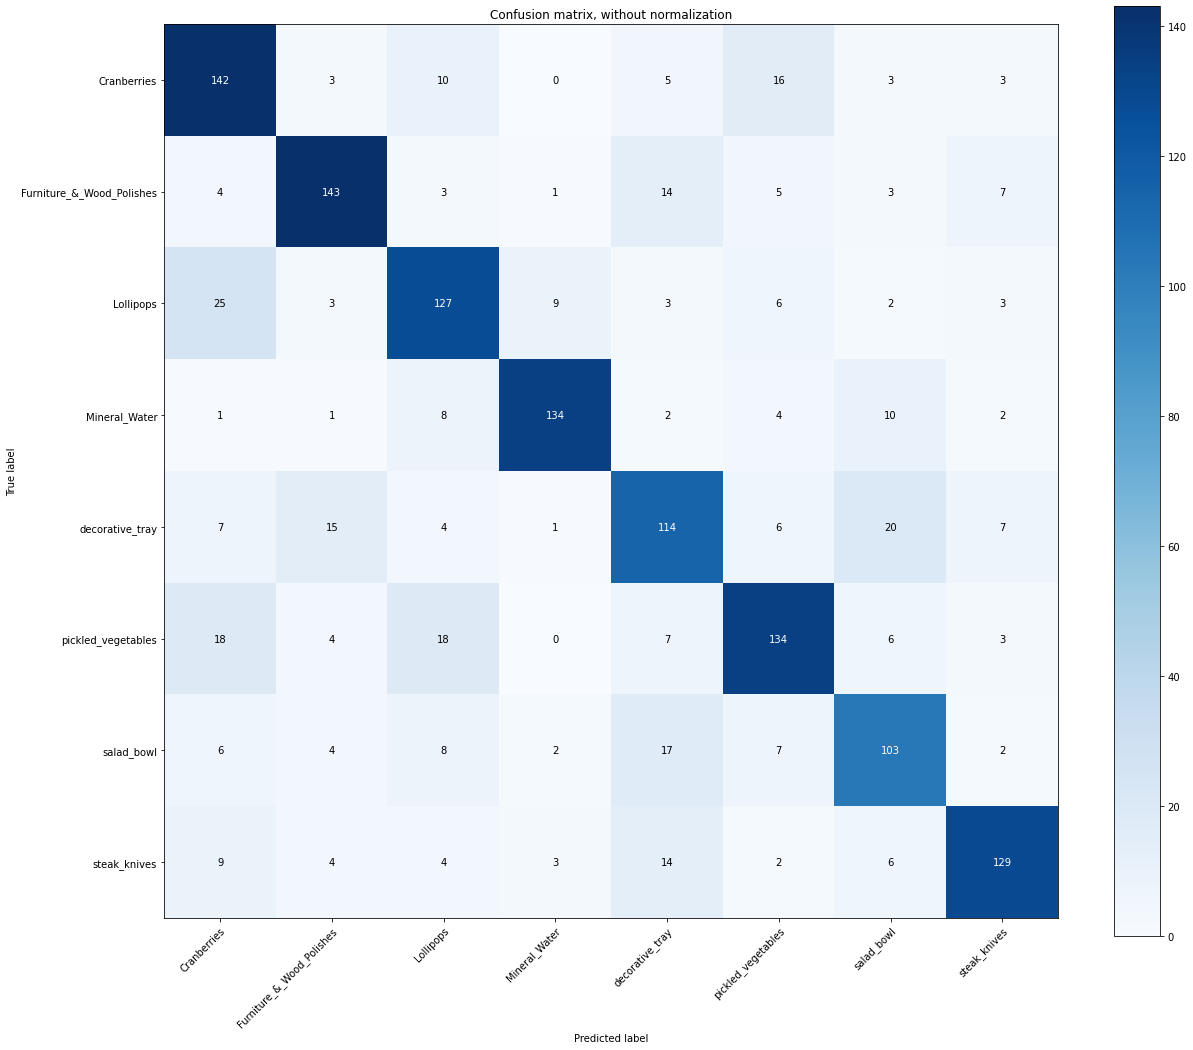

In [29]:
cm = confusion_matrix(test_labels, y_pred, labels=None, sample_weight=None)
print(cm)
plot_confusion_matrix(test_labels, y_pred, classes=class_names, normalize=False)

In [30]:
model2 = Sequential(
    [
        Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32,32,3)),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        GlobalMaxPooling2D(),

        Dense(64, activation='relu'),
        Dense(8, activation='softmax')
    ]
)

In [31]:
# compiling the sequential model
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [32]:
history = model2.fit(x_train, y_train,
                    batch_size=64, epochs=100,
                    validation_data=(x_val, y_val),
                   callbacks=[callback])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
99/99 [==============================] - ETA: 0s - loss: 1.8811 - accuracy: 0.2530WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002088731C318> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attac

99/99 [==============================] - 2s 17ms/step - loss: 0.4292 - accuracy: 0.8478 - val_loss: 0.9076 - val_accuracy: 0.7217
Epoch 46/100
99/99 [==============================] - 2s 17ms/step - loss: 0.4068 - accuracy: 0.8537 - val_loss: 0.8752 - val_accuracy: 0.7217
Epoch 00046: early stopping


In [33]:
model2 = Sequential(
    [
        Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        GlobalMaxPooling2D(),

        Dense(64, activation='relu'),
        Dense(8, activation='softmax')
    ]
)

In [34]:
# compiling the sequential model
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [35]:
history = model2.fit(x_train, y_train,
                    batch_size=64, epochs=100,
                    validation_data=(x_val, y_val),
                   callbacks=[callback])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
99/99 [==============================] - ETA: 0s - loss: 1.9583 - accuracy: 0.2126WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000020887BE5948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attac

In [36]:
model2 = Sequential(
    [
        Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.4),
        Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.4),
        Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.4),
        Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.4),
        GlobalMaxPooling2D(),

        Dense(64, activation='relu'),
        Dense(8, activation='softmax')
    ]
)

In [37]:
# compiling the sequential model
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [38]:
history = model2.fit(x_train, y_train,
                    batch_size=64, epochs=100,
                    validation_data=(x_val, y_val),
                   callbacks=[callback])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
99/99 [==============================] - ETA: 0s - loss: 1.9319 - accuracy: 0.2205WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002098D114F78> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attac

99/99 [==============================] - 3s 30ms/step - loss: 0.3371 - accuracy: 0.8803 - val_loss: 0.8997 - val_accuracy: 0.7344
Epoch 46/100
99/99 [==============================] - 3s 29ms/step - loss: 0.3181 - accuracy: 0.8882 - val_loss: 0.8379 - val_accuracy: 0.7338
Epoch 47/100
99/99 [==============================] - 3s 32ms/step - loss: 0.3256 - accuracy: 0.8844 - val_loss: 0.8637 - val_accuracy: 0.7331
Epoch 48/100
99/99 [==============================] - 3s 30ms/step - loss: 0.3049 - accuracy: 0.8898 - val_loss: 0.9021 - val_accuracy: 0.7363
Epoch 49/100
99/99 [==============================] - 3s 30ms/step - loss: 0.3209 - accuracy: 0.8858 - val_loss: 0.8915 - val_accuracy: 0.7197
Epoch 50/100
99/99 [==============================] - 3s 30ms/step - loss: 0.3299 - accuracy: 0.8854 - val_loss: 0.9199 - val_accuracy: 0.7210
Epoch 51/100
99/99 [==============================] - 3s 30ms/step - loss: 0.2944 - accuracy: 0.8995 - val_loss: 0.9065 - val_accuracy: 0.7338
Epoch 52/100

In [47]:
model3 = Sequential(
    [
        Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.5),
        Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.5),
        Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.5),
        Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.5),
        GlobalMaxPooling2D(),

        Dense(64, activation='relu'),
        Dense(8, activation='softmax')
    ]
)

In [48]:
model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [49]:
history = model3.fit(x_train, y_train,
                    batch_size=64, epochs=100,
                    validation_data=(x_val, y_val),
                   callbacks=[callback])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
99/99 [==============================] - ETA: 0s - loss: 1.9803 - accuracy: 0.2110WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002098FD1C1F8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attac

99/99 [==============================] - 3s 29ms/step - loss: 0.6333 - accuracy: 0.7791 - val_loss: 0.8873 - val_accuracy: 0.7076
Epoch 46/100
99/99 [==============================] - 3s 30ms/step - loss: 0.5953 - accuracy: 0.7936 - val_loss: 0.8923 - val_accuracy: 0.7159
Epoch 47/100
99/99 [==============================] - 3s 30ms/step - loss: 0.5848 - accuracy: 0.7928 - val_loss: 0.8511 - val_accuracy: 0.7293
Epoch 48/100
99/99 [==============================] - 3s 31ms/step - loss: 0.5943 - accuracy: 0.7900 - val_loss: 0.9172 - val_accuracy: 0.7096
Epoch 49/100
99/99 [==============================] - 3s 30ms/step - loss: 0.6093 - accuracy: 0.7858 - val_loss: 0.8626 - val_accuracy: 0.7204
Epoch 50/100
99/99 [==============================] - 3s 30ms/step - loss: 0.5557 - accuracy: 0.8057 - val_loss: 0.8514 - val_accuracy: 0.7299
Epoch 51/100
99/99 [==============================] - 3s 30ms/step - loss: 0.5687 - accuracy: 0.8016 - val_loss: 0.8572 - val_accuracy: 0.7172
Epoch 52/100